## Define local constants
Change these constants based on your needs.

In [45]:
# Input data path
INPUT_DATASETS_TRAINING_CSV = "../data/preprocessed_data/training_dataset_non_lemmatized.csv"
INPUT_DATASETS_TRAINING_LEM = "../data/preprocessed_data/training_dataset.csv"
INPUT_DATASETS_EVALUATION_LEM = "../data/preprocessed_data/evaluation_dataset.csv"
INPUT_DATASETS_EVALUATION = "../data/preprocessed_data/evaluation_dataset_non_lemmatized.csv"
INPUT_DATASET_SST2 = "../data/preprocessed_data/sst2_dict.txt"
INPUT_DATASET_SST2_SENTIMENTS = "../data/preprocessed_data/sst2.txt"
INPUT_DATASET_ORGINAL = "../data/preprocessed_data/orginal/evaluation_paper.csv"
INPUT_DATASET_ORGINAL2 = "../data/preprocessed_data/orginal/training_paper.csv"
METHOD_NAME = "dataset_statistics"
OUTPUT_RESULTS = f"../data/results/{METHOD_NAME}_model.txt"
PATH ="C:/Users/Henry/git/WebMining/roni/web_mining-roni/"

## Import necessary libraries

In [46]:
import pickle
import glob
import yaml
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn import svm
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

## Load and prepare the datasets


In [47]:
dfTraining = pd.read_csv(INPUT_DATASETS_TRAINING_CSV, engine="python", delimiter=",")
dfTrainingLemmatized = pd.read_csv(INPUT_DATASETS_TRAINING_LEM, engine="python", delimiter=",")
dfEvaluation = pd.read_csv(INPUT_DATASETS_EVALUATION, engine="python", delimiter=",")
dfEvaluationLemmatized = pd.read_csv(INPUT_DATASETS_EVALUATION_LEM, engine="python", delimiter=",")


# original paper ds and preprocessing  
dfPaperEvaluationDS = pd.read_csv(INPUT_DATASET_ORGINAL, engine="python", delimiter="," , encoding='latin-1')
#dfPaperEvaluationDS = dfPaperEvaluationDS.drop(["ID", "Date", "NoQuery", "User"],1)
#dfPaperEvaluationDS.loc[dfPaperEvaluationDS.sentiment ==4,'sentiment'] = 1

#SST2 ds
dfSST2 = pd.read_csv(INPUT_DATASET_SST2, engine="python", delimiter="|") 
dfSST2_Sentiments = pd.read_csv(INPUT_DATASET_SST2_SENTIMENTS, engine="python", delimiter=",") 
dfSST2_Sentiments.loc[dfSST2_Sentiments.splitset_label==1,'sentiment'] = 0
dfSST2_Sentiments.loc[dfSST2_Sentiments.splitset_label==2,'sentiment'] = 1
dfSST2.rename(columns ={'0': "sentence_index"},inplace=True)
dfSST2.rename(columns ={'!': "prep_text"},inplace=True)
dfSST2["prep_text"] = dfSST2["prep_text"].str.lower()

In [48]:
#Remove words
filter = ["USERNAME", "EMO", "URL"]
f = lambda x: ' '.join([item for item in str(x).split() if item not in filter])
dfTraining["prep_text"] = dfTraining["prep_text"].apply(f)
dfTrainingLemmatized["prep_text"] = dfTrainingLemmatized["prep_text"].apply(f)
dfEvaluation["prep_text"] = dfEvaluation["prep_text"].apply(f)
dfEvaluationLemmatized["prep_text"] = dfEvaluationLemmatized["prep_text"].apply(f)
dfPaperEvaluationDS["prep_text"] = dfPaperEvaluationDS["prep_text"].apply(f)

In [39]:
def fileSize(paths):
    results_dict={}
    results_dict["file_size"] =Path(r''+PATH+paths.replace("..","",1)).stat().st_size
    print("The file size is:", results_dict["file_size"],"bytes") 
    return results_dict

## Length of tweets

In [40]:
def lengthStatistics(df):
    results_dict= {}
            
    results_dict["avg_length"] = df["prep_text"].str.len().mean()
    print("The average character length of contained tweets: ", results_dict["avg_length"])
    results_dict["max_length"] = df["prep_text"].str.len().max()
    print("The max character length in contained tweets: ",results_dict["max_length"])
    results_dict["avg_word_length"] = df["prep_text"].str.split().apply(len).mean()
    print("The average word count in contained tweets: ",results_dict["avg_word_length"])
    results_dict["max_word_length"] = df["prep_text"].str.split().apply(len).max()
    print("The max word count in contained tweets: ",results_dict["max_word_length"])
    results_dict["numberOfWords"] = df.shape[0]
    print("Number of records in dataset ",results_dict["numberOfWords"])
    df["prep_text_length"] = df["prep_text"].str.len()
    results_dict["ax"] = df.hist(column='prep_text_length', bins=25, grid=False, figsize=(12,8), color='#86bf91', rwidth=0.9)     
    return results_dict
        



## Number of (unique) words

In [42]:
def uniqueWords(df):
    unique = set()
    df['prep_text'].str.lower().str.split().apply(unique.update)
    return len(unique)

def allWords(df):
    return sum(df['prep_text'].apply(lambda x: len(str(x).split(' '))))
    

In [44]:
print(uniqueWords(dfTraining))
allWords(dfTraining)


357888


24286176

## Most common words

In [41]:
def mostCommonWords(df):
    
    stopwords = ["i", "me", "my", "myself", "we", "our", "ours", "ourselves", "you", "your", "yours", "yourself", "yourselves", "he", "him", "his", "himself", "she", "her", "hers", "herself", "it", "its", "itself", "they", "them", "their", "theirs", "themselves", "what", "which", "who", "whom", "this", "that", "these", "those", "am", "is", "are", "was", "were", "be", "been", "being", "have", "has", "had", "having", "do", "does", "did", "doing", "a", "an", "the", "and", "but", "if", "or", "because", "as", "until", "while", "of", "at", "by", "for", "with", "about", "against", "between", "into", "through", "during", "before", "after", "above", "below", "to", "from", "up", "down", "in", "out", "on", "off", "over", "under", "again", "further", "then", "once", "here", "there", "when", "where", "why", "how", "all", "any", "both", "each", "few", "more", "most", "other", "some", "such", "no", "nor", "not", "only", "own", "same", "so", "than", "too", "very", "s", "t", "can", "will", "just", "don", "should", "now", "(",")","'","--","''","n't","'s",".",",","...",'`']
    f = lambda x: ' '.join([item for item in str(x).split() if item not in stopwords])
    df["prep_text"] = df["prep_text"].apply(f)
    return Counter(" ".join(df["prep_text"]).split()).most_common(10)  
    

## Class distribution

In [42]:
def classDistribution(df):
    results_dict= {}
    results_dict["freq"] =df.groupby(["sentiment"]).count()
    print(results_dict["freq"])
    return results_dict

Results  Trainings dataset lemmatized
The average character length of contained tweets:  54.216779287843316
The max character length in contained tweets:  282
The average word count in contained tweets:  11.193079754782195
The max word count in contained tweets:  75
Number of records in dataset  2169663
Results  Evaluation dataset lemmatized
The average character length of contained tweets:  62.88944723618091
The max character length in contained tweets:  262
The average word count in contained tweets:  13.020100502512562
The max word count in contained tweets:  54
Number of records in dataset  199
Results  Trainings dataset
The average character length of contained tweets:  56.22095110710844
The max character length in contained tweets:  287
The average word count in contained tweets:  11.193067488423306
The max word count in contained tweets:  75
Number of records in dataset  2169661
Results  Evaluation dataset
The average character length of contained tweets:  65.39195979899498
The 

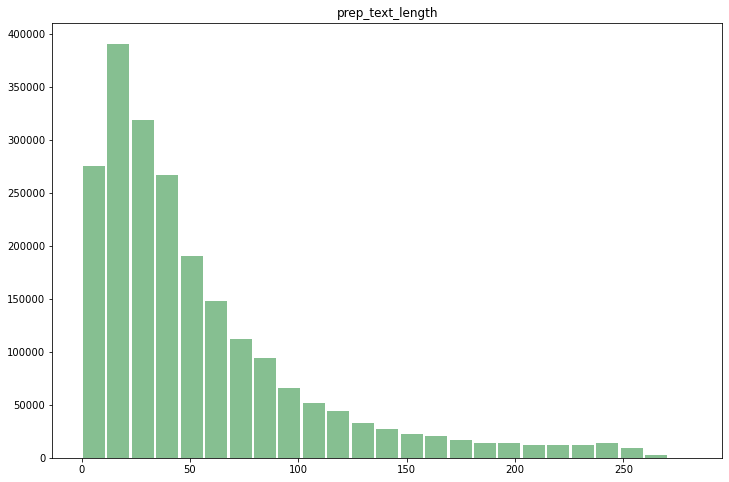

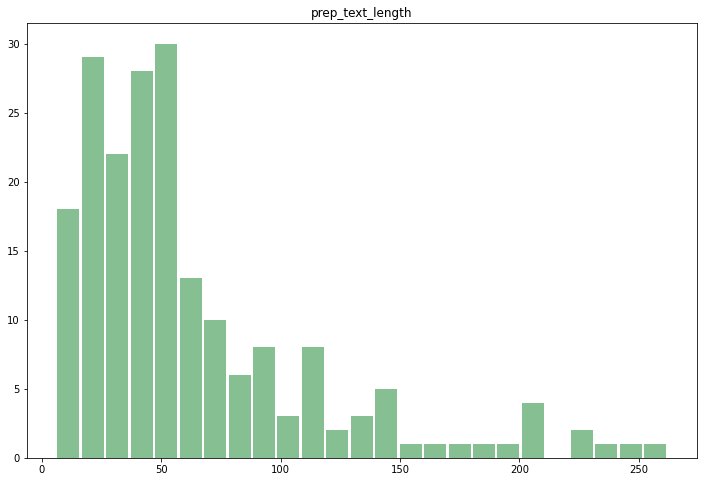

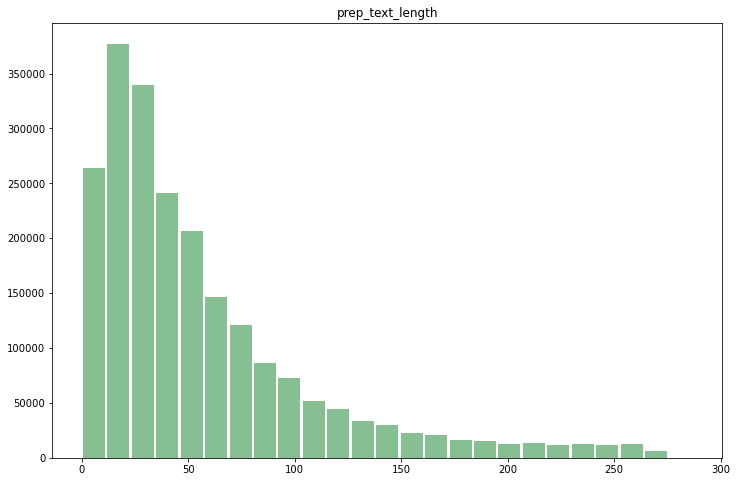

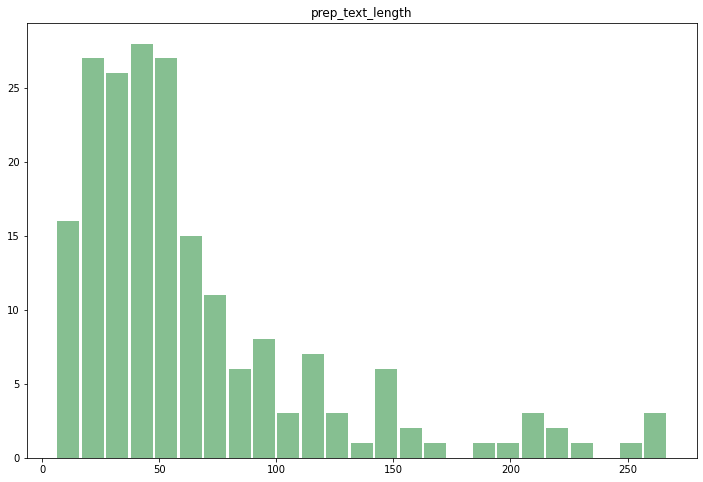

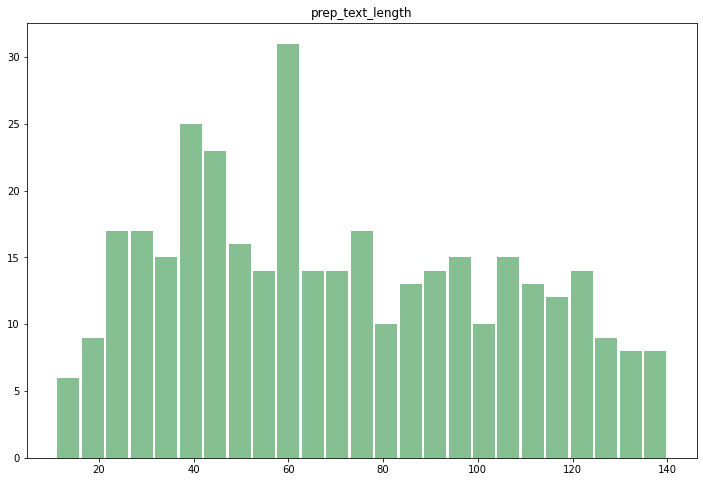

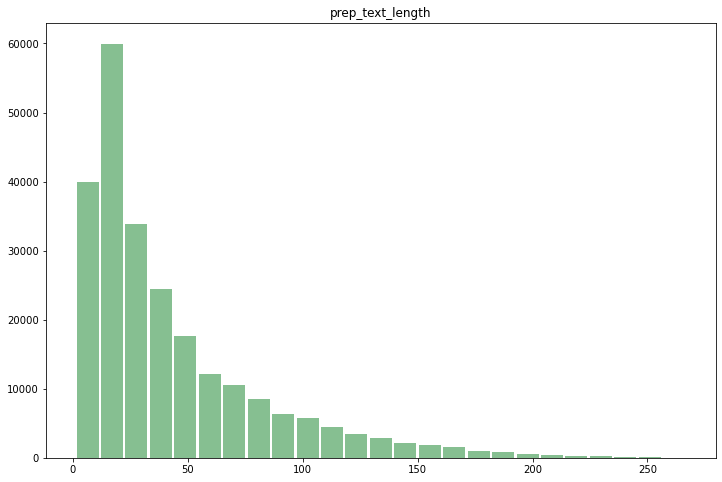

In [43]:

names = ["Trainings dataset lemmatized","Evaluation dataset lemmatized", "Trainings dataset", "Evaluation dataset", "Scientific Paper dataset","SST2 dataset"]
tweets = [dfTrainingLemmatized, dfEvaluationLemmatized, dfTraining, dfEvaluation, dfPaperEvaluationDS, dfSST2]
sentiments = [dfTrainingLemmatized, dfEvaluationLemmatized, dfTraining, dfEvaluation, dfPaperEvaluationDS, dfSST2_Sentiments]
filePaths = [ INPUT_DATASETS_TRAINING_LEM, INPUT_DATASETS_EVALUATION_LEM, INPUT_DATASETS_TRAINING_CSV,INPUT_DATASETS_EVALUATION, INPUT_DATASET_ORGINAL, INPUT_DATASET_SST2]
results_dict_lengthStatistics = {}
results_dict_mostCommonWords = {}
results_dict_sentiments = {}
results_dict_filesize = {}
results_dict_all ={}
for n,t in enumerate(tweets):
    print("Results ",names[n])
    results_dict_lengthStatistics[names[n]+" length statistics"] = lengthStatistics(t)
    results_dict_mostCommonWords[names[n]+" most common words statistics"] = mostCommonWords(t)

for n,s in enumerate(sentiments):
    print("Results ",names[n])    
    results_dict_sentiments[names[n]+" sentiment distribution"] = classDistribution(s)
for n,f in enumerate(filePaths):
    print("Results ",names[n])    
    results_dict_filesize[names[n]+" file Size"]=fileSize(f)

results_dict_all = results_dict_lengthStatistics, results_dict_mostCommonWords, results_dict_sentiments,results_dict_filesize

#print(results_dict_all)
#results = yaml.dump(results_dict_all)

with open(OUTPUT_RESULTS, "w") as file:
    file.write(str(results_dict_all))